In [1]:
#IMPORTS

import argparse
import pickle
import pandas as pd
from scipy.spatial import distance
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import homogeneity_completeness_v_measure,classification_report,confusion_matrix,ConfusionMatrixDisplay
import seaborn as sns

from tqdm import tqdm

import warnings

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster


import numpy as np
import json
import math
import random
import IPython
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

import seaborn as sn

In [2]:
contributors_id_str = "JobMemberId"

In [3]:
# DATA BUILDING FUNCIONS (BUILD CLUSTERS DATAFRAME)

def build_clusters_df(exec_df: pd.DataFrame, embeddings: dict):
    
    cluster_ids = exec_df['cluster'].unique()
    
    clusters_dict = {
    "cluster_id": [],
    "n_utterances": [],
    "jobmembers": [],
    "n_jobmembers": [],
    "main_jobmember": [],
    "dispersion": [],
    "max_dist_utterances": [],
    "mean_dist_utterances": [],
    "median_dist_utterances": []

    }
    
    for cluster_id in cluster_ids:
        cluster_df = exec_df[exec_df['cluster'] == cluster_id]

        n_utterances = len(cluster_df)
        jobmembers = dict(cluster_df.groupby(contributors_id_str).count().HitExecutionId)
        n_jobmembers = len(jobmembers)
        main_jobmember = max(jobmembers, key=(lambda key: jobmembers[key]))
        dispersion = 1 - jobmembers[main_jobmember]/n_utterances
        cluster_emb = [embeddings[elem] for elem in list(cluster_df.HitExecutionId)]
        max_dist_utterances = np.max(distance.pdist(cluster_emb, 'cosine')) if len(cluster_emb) > 1 else 0
        mean_dist_utterances = np.mean(distance.pdist(cluster_emb, 'cosine')) if len(cluster_emb) > 1 else 0
        median_dist_utterances = np.median(distance.pdist(cluster_emb, 'cosine')) if len(cluster_emb) > 1 else 0


        clusters_dict['cluster_id'] += [cluster_id]
        clusters_dict['n_utterances'] += [n_utterances]
        clusters_dict['jobmembers'] += [jobmembers]
        clusters_dict['n_jobmembers'] += [n_jobmembers]
        clusters_dict['main_jobmember'] += [main_jobmember]
        clusters_dict['dispersion'] += [dispersion]
        clusters_dict['max_dist_utterances'] += [max_dist_utterances]
        clusters_dict['mean_dist_utterances'] += [mean_dist_utterances]
        clusters_dict['median_dist_utterances'] += [median_dist_utterances]
        
    return pd.DataFrame.from_dict(clusters_dict)
    

In [4]:
# DATA BUILDING FUNCIONS (BUILD CONTRIBUTORS DATAFRAME)

def build_jobmembers_df(exec_df: pd.DataFrame, clusters_df: pd.DataFrame, embeddings: dict,
                        sev_spk: [], sev_acc: []):
    
    jobmember_ids = exec_df['JobMemberId'].unique()

    jms_dict = {
    "jm_id": [],
    "n_utterances": [],
    "n_clusters": [],
    "clusters": [],
    "main_cluster": [],
    "dispersion": [],
    "max_dist_utterances": [],
    "mean_dist_utterances": [],
    "median_dist_utterances": [],
    "fraud_label" : []
    }
    
    for jm_id in jobmember_ids:
        jm_df = exec_df[exec_df['JobMemberId'] == jm_id]

        n_utterances = len(jm_df)
        clusters = dict(jm_df.groupby('cluster').count().HitExecutionId)
        n_clusters = len(clusters)
        main_cluster = max(clusters, key=(lambda key: clusters[key]))
        dispersion = 1 - clusters[main_cluster]/n_utterances
        jm_emb = [embeddings[elem] for elem in list(jm_df.HitExecutionId)]
        max_dist_utterances = np.max(distance.pdist(jm_emb, 'cosine')) if len(jm_emb) > 1 else 0
        mean_dist_utterances = np.mean(distance.pdist(jm_emb, 'cosine')) if len(jm_emb) > 1 else 0
        median_dist_utterances = np.median(distance.pdist(jm_emb, 'cosine')) if len(jm_emb) > 1 else 0
        
        jms_dict['jm_id'] += [jm_id]
        jms_dict['n_utterances'] += [n_utterances]
        jms_dict['clusters'] += [clusters]
        jms_dict['n_clusters'] += [n_clusters]
        jms_dict['main_cluster'] += [main_cluster]
        jms_dict['dispersion'] += [dispersion]
        jms_dict['max_dist_utterances'] += [max_dist_utterances]
        jms_dict['mean_dist_utterances'] += [mean_dist_utterances]
        jms_dict['median_dist_utterances'] += [median_dist_utterances]
        if jm_id in sev_spk:
            jms_dict['fraud_label'] += [1]
        elif jm_id in sev_acc:
            jms_dict['fraud_label'] += [2]
        else:
            jms_dict['fraud_label'] += [0]
    
    jms_df = pd.DataFrame.from_dict(jms_dict)
    
    jms_df["main_cluster_dispersion"] = jms_df.apply(lambda x: float(clusters_df[clusters_df.cluster_id == x.main_cluster].dispersion), axis=1)
    jms_df["main_cluster_max_dist_utterances"] = jms_df.apply(lambda x: float(clusters_df[clusters_df.cluster_id == x.main_cluster].max_dist_utterances), axis=1)
    jms_df["main_cluster_mean_dist_utterances"] = jms_df.apply(lambda x: float(clusters_df[clusters_df.cluster_id == x.main_cluster].mean_dist_utterances), axis=1)
    jms_df["main_cluster_median_dist_utterances"] = jms_df.apply(lambda x: float(clusters_df[clusters_df.cluster_id == x.main_cluster].median_dist_utterances), axis=1)
    jms_df["sum_cluster_dispersion"] = jms_df.apply(lambda x: float(sum(clusters_df[clusters_df.cluster_id.isin(x.clusters)].dispersion)), axis=1)
           
    return jms_df

In [5]:
def generate_fraud(exec_orig_df: pd.DataFrame, jm_fraud: [], exec_fraud=[1,0.5]):
    """
    Function that generates fraud by changing jobmember ids.
    
    Optionally, a list can be provided to explicity select a fraction of executions to move.
        default of several speakers is all; default for several accounts is half).
    
    There is no intersection of frauds in this iteration.
    """
    
    
    exec_df = exec_orig_df.copy()
    
    jm_ids = exec_df['JobMemberId'].unique()
    n_jm = len(jm_ids)
    if VERBOSE_FRAUD:
        print ('There are initially', n_jm, 'Job Members in this Job.')
    
    # read percentage of fraudulent jobmembers
    if len(jm_fraud) == 2:
        several_spk = math.floor(jm_fraud[0]*n_jm)
        several_acc = math.floor(jm_fraud[1]*n_jm)
        
    elif len(jm_fraud) == 1:
        several_spk = math.floor(jm_fraud*n_jm)
        several_acc = math.floor(jm_fraud*n_jm)
        
    else:
        raise TypeError("jm_fraud must an array of size 1 or 2")
    
    # read fraction of fraud per fradulent jobmember
    if len(exec_fraud) == 2:
        exec_spk, exec_acc = exec_fraud
        
    elif len(exec_fraud) == 1:
        exec_spk = exec_fraud[0]
        exec_acc = exec_fraud[0]
        
    else:
        raise TypeError("jm_fraud must an array of size 1 or 2")
    
    if VERBOSE_FRAUD:    
        print(f"From {len(jm_ids)} selecting {several_acc} for several speaker fraud and {several_spk} for several account fraud")

    sample = random.sample(list(jm_ids),2*several_spk+several_acc)
    
    several_spk_source = sample[0:several_spk]
    several_spk_target = sample[several_spk:2*several_spk]
    several_acc_source = sample[2*several_spk:2*several_spk+several_acc]
    several_acc_target = list(range(0,several_acc))
    
    # Move executions to other Jobmember
    for source,target in zip(several_spk_source,several_spk_target):
        
        n_exec = len(exec_df.loc[(exec_df['JobMemberId'] == source)])
        n_move = math.floor(exec_spk*n_exec)
        exec_set = exec_df.loc[(exec_df['JobMemberId'] == source)]['HitExecutionId'].unique()
        exec_set_go = exec_set[:n_move]
        exec_set_del = exec_set[n_move:]
        
        if VERBOSE_FRAUD:
            print(f"Jobmember {source} will have {n_move}/{n_exec} executions moved to {target}")
        exec_df.loc[(exec_orig_df['JobMemberId'] == source) & (exec_df['HitExecutionId'].isin(exec_set_go)), 'JobMemberId'] = target
        
        # delete remaining
        exec_df.drop(exec_df.loc[exec_df['HitExecutionId'].isin(exec_set_del)].index, inplace=True)
        
    # Move executions to new Jobmember
    for source,target in zip(several_acc_source,several_acc_target):
        n_exec = len(exec_df.loc[(exec_df['JobMemberId'] == source)])
        n_move = math.floor(exec_acc*n_exec)
        exec_set = exec_df.loc[(exec_df['JobMemberId'] == source)]['HitExecutionId'].unique()[:n_move]
                
        if VERBOSE_FRAUD:
            print(f"Jobmember {source} will have {n_move}/{n_exec} executions moved to {target}")
            
        exec_df.loc[(exec_df['JobMemberId'] == source) & (exec_df['HitExecutionId'].isin(exec_set)), 'JobMemberId'] = target
    
    jm_ids = exec_df['JobMemberId'].unique()
    if VERBOSE_FRAUD:
        print ('There are now', len(jm_ids), 'Job Members in this Job.')
    
    return exec_df, several_spk_source+several_spk_target, several_acc_source+several_acc_target

In [6]:
# DATA BUILDING FUNCIONS (CLUSTER DATA)

def cluster_data(exec_df: pd.DataFrame, embeddings: dict, sev_spk: [], sev_acc: []):
    
    new_exec_df = exec_df[exec_df['HitExecutionId'].isin(embeddings.keys())].copy()
    
    emb = {key: value for key, value in embeddings.items() if key in list(exec_df['HitExecutionId'])}
        
    jobmember_ids = new_exec_df['JobMemberId'].unique()
    
    if VERBOSE_PURE:
        print ('There are', len(jobmember_ids), 'Job Members in this Job.')
    
    clustering = AgglomerativeClustering(n_clusters=len(jobmember_ids), affinity='cosine', linkage='complete').fit(list(emb.values()))
    clst_labels = clustering.labels_
    new_exec_df['cluster']=clst_labels
    
    clusters_df = build_clusters_df(new_exec_df, embeddings)
    
    jms_df = build_jobmembers_df(new_exec_df, clusters_df, emb, sev_spk, sev_acc)
    
    v_measure=homogeneity_completeness_v_measure([int(new_exec_df.loc[new_exec_df['HitExecutionId']==x,'JobMemberId']) for x in emb.keys()], clst_labels)
    
    if VERBOSE_PURE:
        print(f"V-Measure: {v_measure}")
    return clusters_df, jms_df, new_exec_df, v_measure

# EXPERIMENTS

In [7]:
warnings.filterwarnings("ignore")


In [8]:
EXEC_FILE_PATH = "vox1.tsv"
EMBEDDS_FILE_PATH = "vox1test_ecapa_embbs.pkl"

exec_df = pd.read_csv(EXEC_FILE_PATH, delimiter="\t")

with open(EMBEDDS_FILE_PATH, 'rb') as f:
    orig_embeddings = pickle.load(f)
    embeddings = {key: value for key, value in orig_embeddings.items()}

VERBOSE_FRAUD = False
VERBOSE_PURE = False


final_y = []
final_y_hat = []
# exec_orig_df has not been filtered, forcing filtering via cluster_data
clusters_df_orig, jms_df_orig, exec_df_orig, _ = cluster_data(exec_df, embeddings,[], [])


# Defining the amount of Fraud
jm_fraud = [0.05,0.05]
exec_fraud = [1,0.5]
execc = exec_df_orig.copy()
emb = embeddings.copy()

# Generating Fraud and clustering
exec_df_fraud, sev_spk, sev_acc = generate_fraud(execc, jm_fraud=jm_fraud, exec_fraud=exec_fraud)
clusters_df, fraud_jms_df, exec_df, _ = cluster_data(exec_df_fraud, emb, sev_spk, sev_acc)
jm_df = fraud_jms_df.copy()

pure_jms = list(fraud_jms_df[(fraud_jms_df['dispersion']==0) & (fraud_jms_df['main_cluster_dispersion']==0)].jm_id)

has_multiple_speakers = True
has_multiple_accounts = True

iteration_nb = 1

multiple_speaker_set = set()
multiple_account_set = set()

# Detection loop
while has_multiple_speakers or has_multiple_accounts:

    fraudulent_jms_df = fraud_jms_df[fraud_jms_df['n_clusters']==1].groupby('main_cluster').filter(lambda g: len(g) > 1)
    fraudulent_jms = list(fraudulent_jms_df.jm_id)

    has_multiple_accounts= len(fraudulent_jms)>0

    if has_multiple_accounts:
        multiple_account_set.update(fraudulent_jms)
        exec_df = exec_df[~exec_df[contributors_id_str].isin(fraudulent_jms)].copy()
        emb = {hitexec_id: embeddings[hitexec_id] for hitexec_id in exec_df['HitExecutionId']}
        clusters_df, fraud_jms_df, exec_df,_ = cluster_data(exec_df, emb, [], [])

    multiple_speaker_ids = list(fraud_jms_df[(fraud_jms_df['n_clusters'] > 1) & (fraud_jms_df['sum_cluster_dispersion'] == 0)].sort_values('max_dist_utterances', ascending=False).jm_id)

    has_multiple_speakers = len(multiple_speaker_ids)>0

    if has_multiple_speakers:
        multiple_speaker_set.update(multiple_speaker_ids)
        exec_df = exec_df[~exec_df[contributors_id_str].isin(multiple_speaker_ids)].copy()
        emb = {hitexec_id: embeddings[hitexec_id] for hitexec_id in exec_df['HitExecutionId']}
        clusters_df, fraud_jms_df, exec_df,_ = cluster_data(exec_df, emb, [], [])

    iteration_nb+=1

new_pure_jms = list(fraud_jms_df[(fraud_jms_df['dispersion']==0) 
                            & (fraud_jms_df['main_cluster_dispersion']==0)].sort_values('max_dist_utterances', ascending=False).jm_id)


remaining_jms_df = fraud_jms_df[~fraud_jms_df["jm_id"].isin(new_pure_jms)]
remaining_jms_ids = list(remaining_jms_df.jm_id)



y_hat = len(new_pure_jms) * [0] + len(multiple_speaker_set) * [1] + len(multiple_account_set) * [2] + len(remaining_jms_ids) * [3]

y = [int(jm_df.loc[jm_df['jm_id']==x,'fraud_label']) for x in new_pure_jms+list(multiple_speaker_set)+list(multiple_account_set)+list(remaining_jms_ids)]

final_y.extend(y)
final_y_hat.extend(y_hat)

aux = classification_report(y,y_hat,output_dict=True)
aux['n_inc'] = len(remaining_jms_ids)/len(y)
    


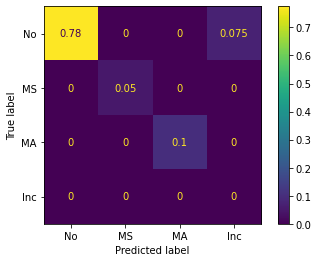

In [9]:
cm = confusion_matrix(final_y, final_y_hat,normalize='all')

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["No", "MS", "MA", "Inc"])
f = disp.plot() 

